<b> Functions <b>

In [76]:
from qutip import *
import pylab as py
import numpy as np
import matplotlib.pyplot as plt


def heaviside(x):
    if x >= 0 :
        return 1
    if x < 0 :
        return 0
    
def nega(rho, subsys):
    
    #create mask which counts the number of possible subsystems
    x = [0 for i in rho.dims[0]]
   
    #assigns a 1 in the position of the subsystem for which we want to compute the negativity
    x[subsys] = 1
        
    #takes partial transpose with respect to subsys x
    rho_pt = partial_transpose(rho, x)
    
    #finds eivenvalues of pt matrix
    eig = rho_pt.eigenenergies()
    
    #finds abs value of the eigenvalues
    abs_eig = abs(eig)
    
    negat = 0 #initialize value of negativity
    
    #takes the difference 
    diff = (abs_eig - eig)
    
    
    #computes negativity
    for el in diff:
        negat += el
    
    return negat

<b> Parameters <b>

In [83]:
#time settings
ti = 0 #initial time
tf = 10**(-9)*50 #final time
steps = 5001 #number of steps
tau_list = np.linspace(ti,tf,steps) # vector of time steps

cycles = 41 # number of variations of parameters
pi = 0.5
pf = 1.5
par_list = np.linspace(pi,pf,cycles)
par_range = [0 for i in range(cycles)]

print(par_list)


#initialize entanglement measures vectors
neg = np.zeros([cycles, steps]) #negativity

mut = np.zeros([cycles, steps]) #mutual information

conc = np.zeros([cycles, steps]) #concurrence

q_ex = np.zeros([cycles, steps])




[ 0.5    0.525  0.55   0.575  0.6    0.625  0.65   0.675  0.7    0.725
  0.75   0.775  0.8    0.825  0.85   0.875  0.9    0.925  0.95   0.975  1.
  1.025  1.05   1.075  1.1    1.125  1.15   1.175  1.2    1.225  1.25
  1.275  1.3    1.325  1.35   1.375  1.4    1.425  1.45   1.475  1.5  ]


<b> Numerical solution <b>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


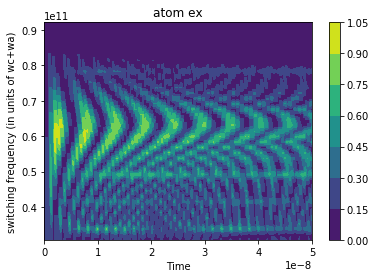

In [84]:
   
for j in range(0, cycles):
    
    wc = 10**(9)*2*np.pi*5.439  # frequency of the cavity photons
    wa = 10**(9)*2*np.pi*4.343  # transition frequency of the qubits
    
    par_range[j] = (wc+wa)*par_list[j] 
    #print(par_range[j])

    N = 4      # number of cavity fock states (N-1 photons inn the cavity)
    n_th_a = 0.0           # temperature in frequency units
    g = 10**(6)*2*np.pi*300 # coupling strength

#     kappa = 2*np.pi*1.6*10**(6)      # cavity dissipation rate
#     gamma1 = 2*np.pi*7.6*10**(3)     # atom 1 dissipation rate
#     gamma2 = 2*np.pi*7.6*10**(3)     # atom 2 dissipation rate

    kappa = 1.6*2*np.pi*1.6*10**(6)     # cavity dissipation rate
    gamma1 = 7.6*2*np.pi*1.6*10**(3)     # atom 1 dissipation rate
    gamma_phi1 = 3*2*np.pi*1.6*10**(3)     # atom 1 dephasing rate





    # intial state (ground state)
    psi0 = tensor(basis(N,1), basis(2,0)) #, basis(2,0))    # start with 0 excited atom and 0 photons



    # density matrix
    rho0 = ket2dm(psi0) #turns ket into a density matrix




    # operators
    a  = tensor(destroy(N), qeye(2) )#, qeye(2)) #destroy cavity photon
    sm1 = tensor(qeye(N), destroy(2) )#, qeye(2)) #destroy atom1 excitation
    #sm2 = tensor(qeye(N), qeye(2), destroy(2)) #destroy atom2 excitation


    #list of collapse operator (dissipation ops) for separate baths (for Lindblad's equation)    
    c_op_list = []

    rate = kappa #photon dissipation
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * a) 


    rate = gamma1 #atom1 dissipation
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm1)

    rate = gamma_phi1 #atom1 dephasing
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * ((sm1.dag()*sm1 - qeye(1))/2) )




    # Rabi model Hamiltonian for two atoms and a cavity mode for time dependent coupling

    def H1_coeff(t,args):
        coeff = g*heaviside(np.cos((wc-wa)*par_list[j]*t)) #
        return coeff

    H0 = wc*a.dag()*a + wa*sm1.dag()*sm1 #+ wa*sm2.dag()*sm2

    H1 = a.dag()*sm1 + a*sm1.dag() + a*sm1 + a.dag()*sm1.dag() # + a.dag()*sm2 + a*sm2.dag() + a*sm2 + a.dag()*sm2.dag())


    H = [H0,[H1,H1_coeff]]





    #solve master equation
    output = mesolve(H, rho0, tau_list, c_op_list ,[a.dag() * a, sm1.dag() * sm1]) #, sm2.dag() * sm2])  #stores expectation values of number of phontons, excitation of atom 1 and 2 

    #result = mesolve(H, rho0, tau_list, c_op_list)  #stores density matrix operator changing in time


    # plot excitation probabilities of photons and atoms
#     plt.plot(tau_list, output.expect[0], label="Cavity")
#     plt.plot(tau_list, output.expect[1], label="Atom 1 excited state")
#     plt.plot(tau_list, output.expect[2], label="Atom 2 excited state")
#     plt.legend()
#     plt.xlabel('Time')
#     plt.ylabel('Occupation probability')
#     plt.title('Vacuum Rabi oscillations');
#     plt.show()



    #x = [1,2] # selects the system to NOT trace over (0=photons, 1=atom1, 2=atom2)

    #for i in range(steps):
        #states = result.states[i]*result.states[i].dag() # creates density matrix at each time 

        #rhoqub = states.ptrace(x) # traces over the photonic degrees of freedom to obtain the density matrix of the qubits

        #conc[j][i] = concurrence(rhoqub) # computes concurrence between qubits 
        
        #print(conc)

        #mut[j][i] = entropy_mutual(rhoqub,0,1) #computes mutual information between the qubits

        #neg[j][i] = nega(states, 1) #computes negativity between a qubit and the rest of the system
        
    q_ex[j] = output.expect[1]
    
#     plt.plot(tau_list, q_ex[j], label="Atom 1 excited state")
#     plt.legend()
#     plt.xlabel('Time')
#     plt.ylabel('Occupation probability')
#     plt.title('Vacuum Rabi oscillations');
#     plt.show()

    
    print(j)
    
plt.contourf(tau_list,par_range,q_ex)
plt.xlabel('Time')
plt.ylabel('switching frequency (in units of wc+wa)')
plt.colorbar()  # draw colorbar
plt.title('atom ex')
plt.show()





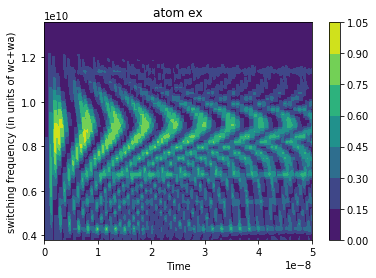

In [85]:
par_range_prime = [0 for i in range(cycles)]


for j in range(0,cycles):
    par_range_prime[j] = (par_range[j] - (wc-wa))/(2*np.pi)


plt.contourf(tau_list,par_range_prime,q_ex)
plt.xlabel('Time')
plt.ylabel('switching frequency (in units of wc+wa)')
plt.colorbar()  # draw colorbar
plt.title('atom ex')
plt.show()
